In [ ]:
#chaper6

In [3]:
import torch
import torch.nn as nn

In [4]:
import pandas
import matplotlib.pyplot as plt

In [5]:
import random

def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2)]
  )
  return real_data

generate_real()

tensor([0.8056, 0.0849, 0.8149, 0.1977])

In [6]:
class Discriminator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()
    
    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(4, 3),
        nn.Sigmoid(),
        nn.Linear(3, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()
    
    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [7]:
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [8]:
D = Discriminator()

for i in range(10000):
  # 실제 데이터
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000


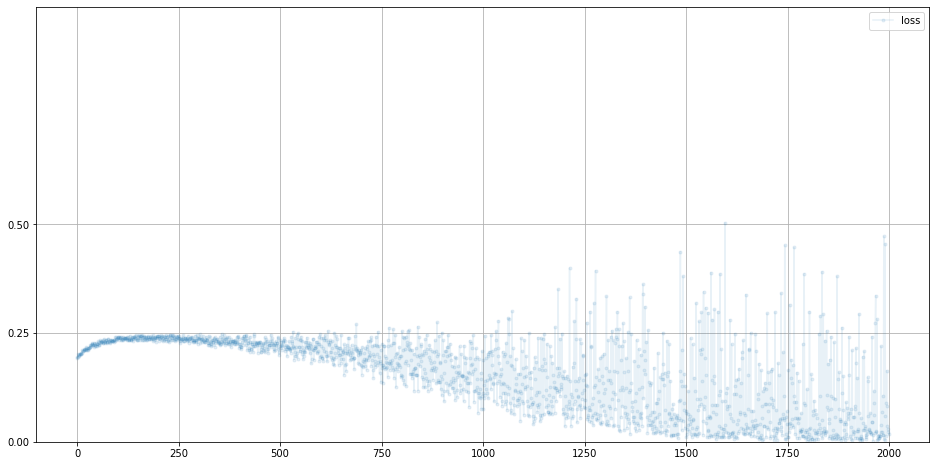

In [9]:
D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7740397453308105
0.2589642405509949


In [11]:
class Generator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Sigmoid(),
        nn.Linear(3, 4),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass
  pass

In [12]:
# check the generator output is of the right type and shape
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5693, 0.5649, 0.5385, 0.5946], grad_fn=<SigmoidBackward>)

In [13]:
# 판별기 및 생성기 생성
D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련
for i in range(10000):
  # 1단계: 참에 대해 판별기 훈련
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  # 매 1000회 이미지를 저장
  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())
  
  pass

counter =  10000
counter =  20000


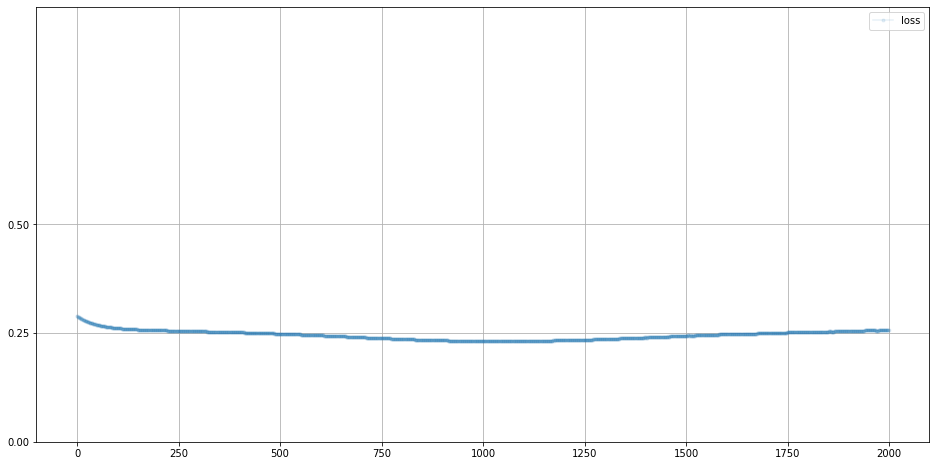

In [15]:
# plot discriminator eroor
D.plot_progress()

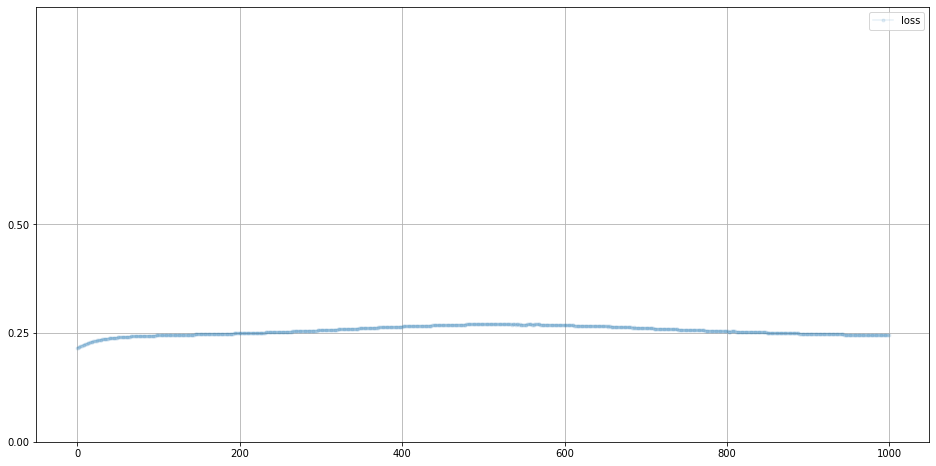

In [16]:
# plot generator error
G.plot_progress()

In [17]:
# manually run generator to see it's ouputs
G.forward(torch.FloatTensor([0.5]))

tensor([0.9011, 0.0600, 0.8852, 0.0686], grad_fn=<SigmoidBackward>)

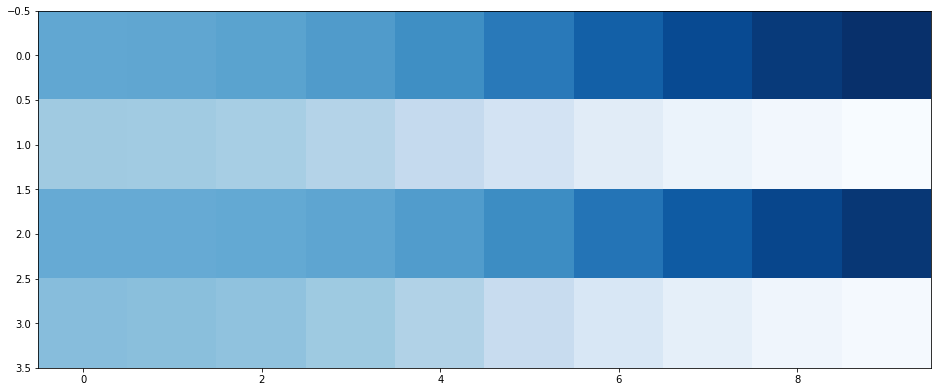

In [19]:
import numpy
plt.figure(figsize=(16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

In [20]:
#chapter7

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [22]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [23]:
class MnistDataset(Dataset):
  
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass
  
  def __len__(self):
    return len(slef.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target
  
  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
  
  pass

In [24]:
# load data
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

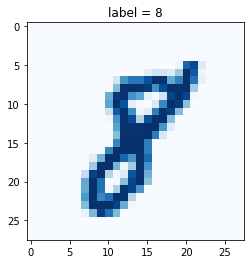

In [25]:
# check data contains images
mnist_dataset.plot_image(17)

In [35]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200), 
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

In [36]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [37]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 48s, sys: 3.56 s, total: 3min 51s
Wall time: 3min 51s


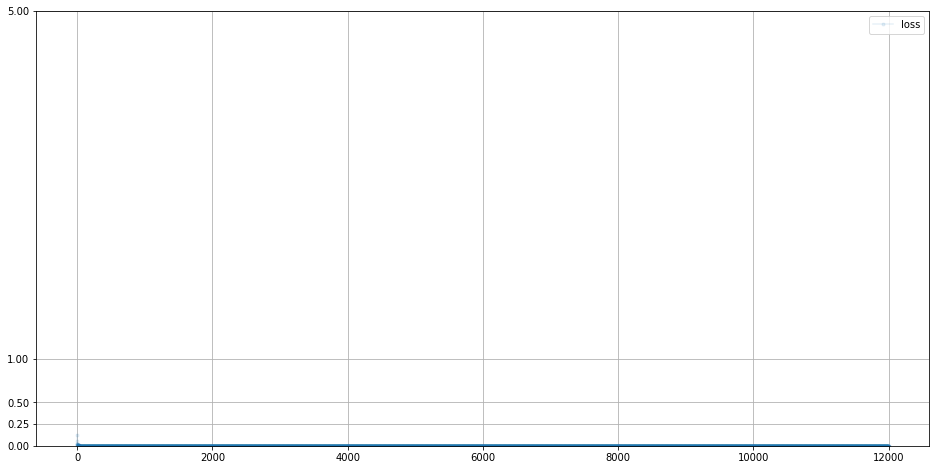

In [38]:
D.plot_progress()

In [39]:
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

1.0
1.0
1.0
1.0
9.399454305170085e-12
9.071942849714354e-12
8.92536912433517e-12
9.536045564306761e-12


In [40]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 200), 
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

In [43]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data


In [44]:
%%time

D = Discriminator()
G = Generator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

  G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 6min 33s, sys: 6.44 s, total: 6min 39s
Wall time: 6min 39s


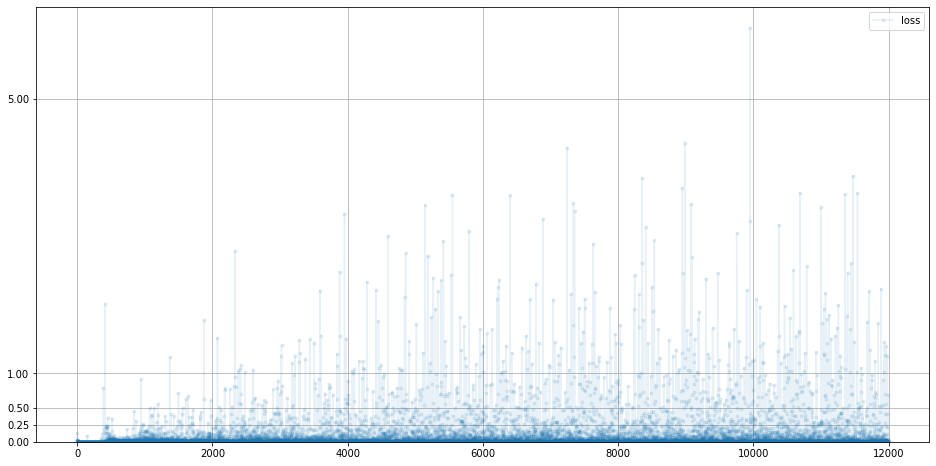

In [46]:
D.plot_progress()

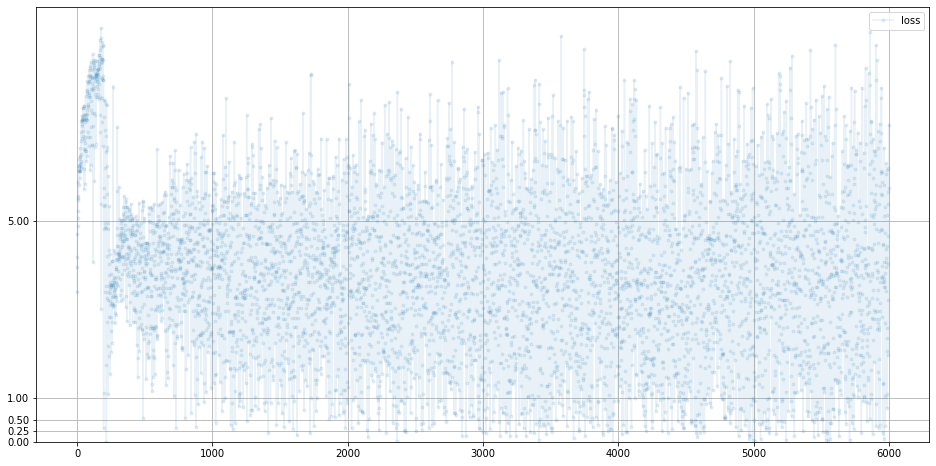

In [47]:
G.plot_progress()

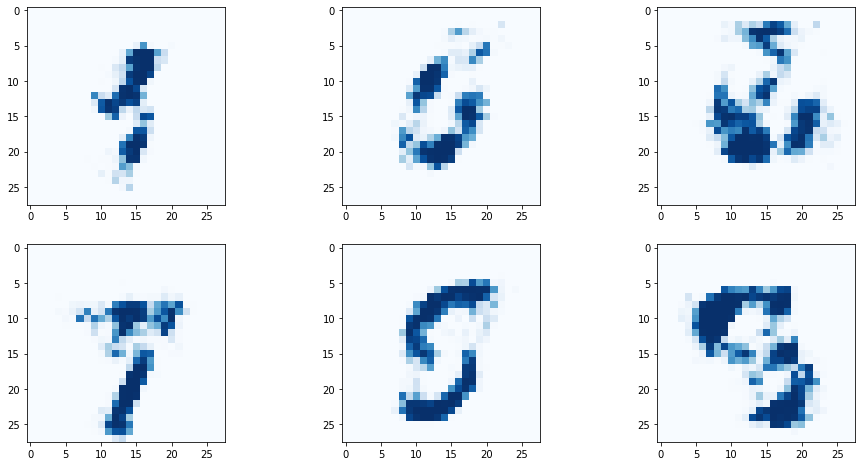

In [48]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass

In [49]:
%%time

epochs = 4

D = Discriminator()
G = Generator()

for i in range(epochs):
  for label, image_data_tensor, target_tensor in mnist_dataset:
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 26min 26s, sys: 23.7 s, total: 26min 49s
Wall time: 26min 48s


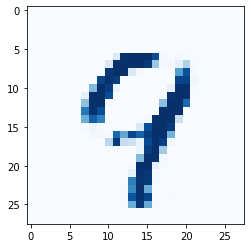

In [50]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28, 28)
plt.imshow(img1, interpolation = 'none', cmap = 'Blues')

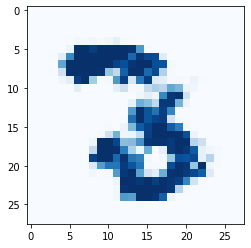

In [51]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28, 28)
plt.imshow(img2, interpolation = 'none', cmap='Blues')

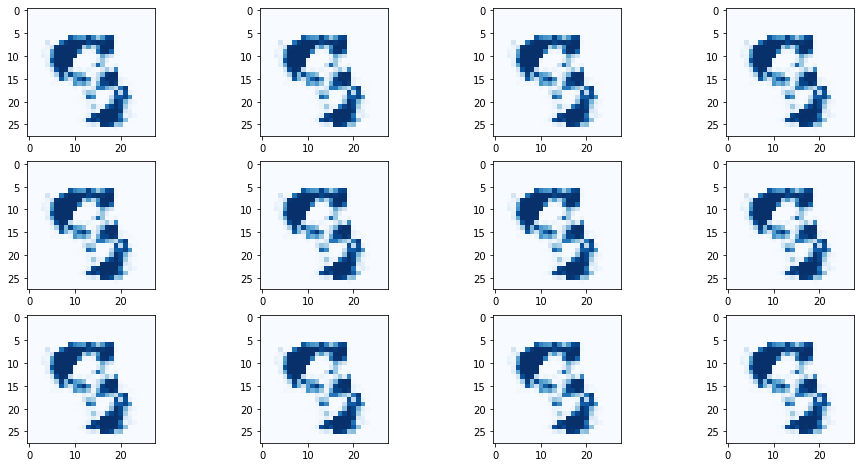

In [55]:
count = 0

#seed1 = generate_random_seed(100)
#seed2 = generate_random_seed(100)

f, axarr = plt.subplots(3, 4, figsize = (16, 8))
for i in range(3):
  for j in range(4):
    seed = seed1 + (seed2 - seed1)/11 * count
    coutput = G.forward(seed)
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation = 'none', cmap='Blues')
    count = count +1
    pass
  pass

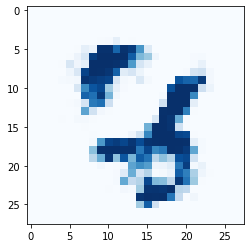

In [54]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28, 28)
plt.imshow(img3, interpolation = 'none', cmap = 'Blues')

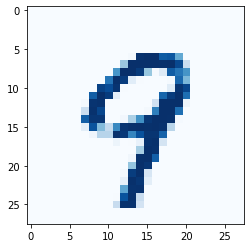

In [56]:
seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28, 28)
plt.imshow(img4, interpolation = 'none', cmap='Blues')

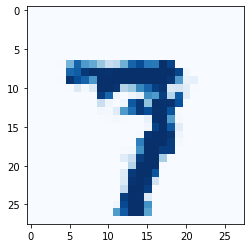

In [57]:
seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

In [58]:
#chpater8

In [67]:
import h5py
import numpy
import matplotlib.pyplot as plt

In [68]:
import torchvision.datasets

In [ ]:
# download data

mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

In [70]:
import zipfile
import imageio
import os

In [ ]:
%%time

hdf5_file = 'mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py'

total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:
  count = 0

  with zipfile.ZipFile('mount/My Drive/Colab Notebooks/myo_gan/celeba/img_align_celeba_20000.zip', 'r') as zf:
    for i in zf.namelist():
      if(i[-4:] == '.jpg'):
        ofile = zf.extract(i)
        img = imageio.imread(ofile)
        os.remove(ofile)

        hf.create_dataset('img_align_celeba/' + str(count)+'.jpg', data = img, compression = "gzip", compression_opts = 9)

        count = count +1
        if(count % 1000 == 0):
          print("images done ..", count)
          pass

        if(count == total_images):
          break
        pass

      pass

    pass

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [74]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [75]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [76]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [77]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [78]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
%%time

D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
  pass

In [ ]:
D.plot_progress()

In [81]:
#생성기
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 3*10*10), 
        nn.LeakyReLU(),

        nn.LayerNorm(3*10*10),

        nn.Linear(3*10*10, 3*218*178),
        nn.Sigmoid(),

        View((218, 178, 3))
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

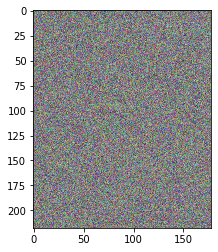

In [82]:
G = Generator()
G.to(device)#모델을 CUDA에 배치

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation = 'none', cmap='Blues')